In [1]:
import datetime
import logging
import os
import glob 
from datetime import datetime, timedelta
import re

from pathlib import Path
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import numpy as np
from pyproj import Transformer
from sklearn.metrics import cohen_kappa_score
from shapely.geometry import LinearRing, Point, Polygon, box
import rasterio
import requests
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
from pprint import pprint


In [2]:
# Flag for testing cloud addition
test_add_cloud = False

def gdal_load(path, band):
    """
    Load image file into array
    using gdal.
    
    Parameters
    ----------
    path : str
        Path to image file
    band : int
        Band number to load (1-based indexing)
    
    Returns
    -------
    arr : np.ndarray
        Loaded image data
    x : np.ndarray
        X-coordinates in projected space
    y : np.ndarray
        Y-coordinates in projected space
    """
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    arr = ds.GetRasterBand(band).ReadAsArray()
    #length, width = ds.RasterYSize, ds.RasterXSize
    # We also save the raster geo info to use them for plotting later 
    # ulx, uly stands for upper left corner, lrx, lry for lower right corner
    ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()
    x = ulx + np.arange(ds.RasterXSize, dtype=float) * xres
    y = uly + np.arange(ds.RasterYSize, dtype=float) * yres
    # this empties the gdal raster variable that we no longer need since the raster has been saved into and array
    ds = None 

    return arr, x, y

In [3]:
# Custom colormaps
# Define colormaps for plotting different DSWx class combinations
black_blue = ListedColormap(['black', 'Blue'])
black_white = ListedColormap(['black', 'white'])
black_blue_white = ListedColormap(['black', 'blue', 'white'])
white_blue = LinearSegmentedColormap.from_list('white_blue', ['white', 'blue'])

# Custom HLS comparison colormap for visual inspection
HLS_compare_colors = ['white', 'blue', 'lightblue', 'darkgrey', 'black']
HLS_compare_cmap = ListedColormap(HLS_compare_colors)
HLS_compare_bounds = [-0.5, 0.5, 1.5, 2.5, 254, 256]
HLS_compare_norm = BoundaryNorm(HLS_compare_bounds, HLS_compare_cmap.N)

# Simplified HLS map (without partial surface water)
HLS_colors = ['white', 'blue', 'darkgrey', 'black']
HLS_cmap = ListedColormap(HLS_colors)
HLS_bounds = [-0.5, 0.5, 1.5, 254, 256]
HLS_norm = BoundaryNorm(HLS_bounds, HLS_cmap.N)

In [4]:
# Define paths and load lists of HLS and S1 files
mgrs_tile = "10SFH"
read_fp = "/u/aurora-r0/jeon/tools/DSWx-fusion/DSWx-Enhanced-Analysis/download_"

# List HLS files
files_HLS = glob.glob(read_fp + mgrs_tile + "/*-HLS_*")
files_HLS_WTR = sorted(glob.glob(read_fp + mgrs_tile + "/*-HLS_*_WTR.tif"))
print("# HLS WTR: " + str(len(files_HLS_WTR)))

# List S1 files
files_S1 = glob.glob(read_fp + mgrs_tile + "/*-S1_*")
files_S1_WTR = sorted(glob.glob(read_fp + mgrs_tile + "/*-S1_*_WTR.tif"))
print("# S1 WTR: " + str(len(files_S1_WTR)))

# HLS WTR: 323
# S1 WTR: 174


In [5]:
def extract_datetime(filename):
    """
    Extract ISO datetime from filename.
    """
    #match = re.search(r'(\d{8}T\d{6}Z)', filename)  # Get start date
    match = re.search(r'_(\d{8}T\d{6}Z)', filename)  # Get end date
    if match:
        #return datetime.strptime(match.group(), "%Y%m%dT%H%M%SZ")  # Start date
        return datetime.strptime(match.group(1), "%Y%m%dT%H%M%SZ")  # End date
    return None

# load HLS and S1 images and stack it into 3d array
data_stack = []
dates_HLS_WTR = []

for fp in files_HLS_WTR:
    data, x, y = gdal_load(fp, 1)
    data_stack.append(data)
    dates_HLS_WTR.append(extract_datetime(fp))

whole_data_HLS_WTR = np.stack(data_stack, axis = -1) # stack of all historical HLS data

data_stack = []
dates_S1_WTR = []

for fp in files_S1_WTR:
    data, x, y = gdal_load(fp, 1)
    data_stack.append(data)
    dates_S1_WTR.append(extract_datetime(fp))


whole_data_S1_WTR = np.stack(data_stack, axis = -1) # stack of all historical S1 data


/u/aurora-r0/jeon/tools/anaconda3/envs/dswx-env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


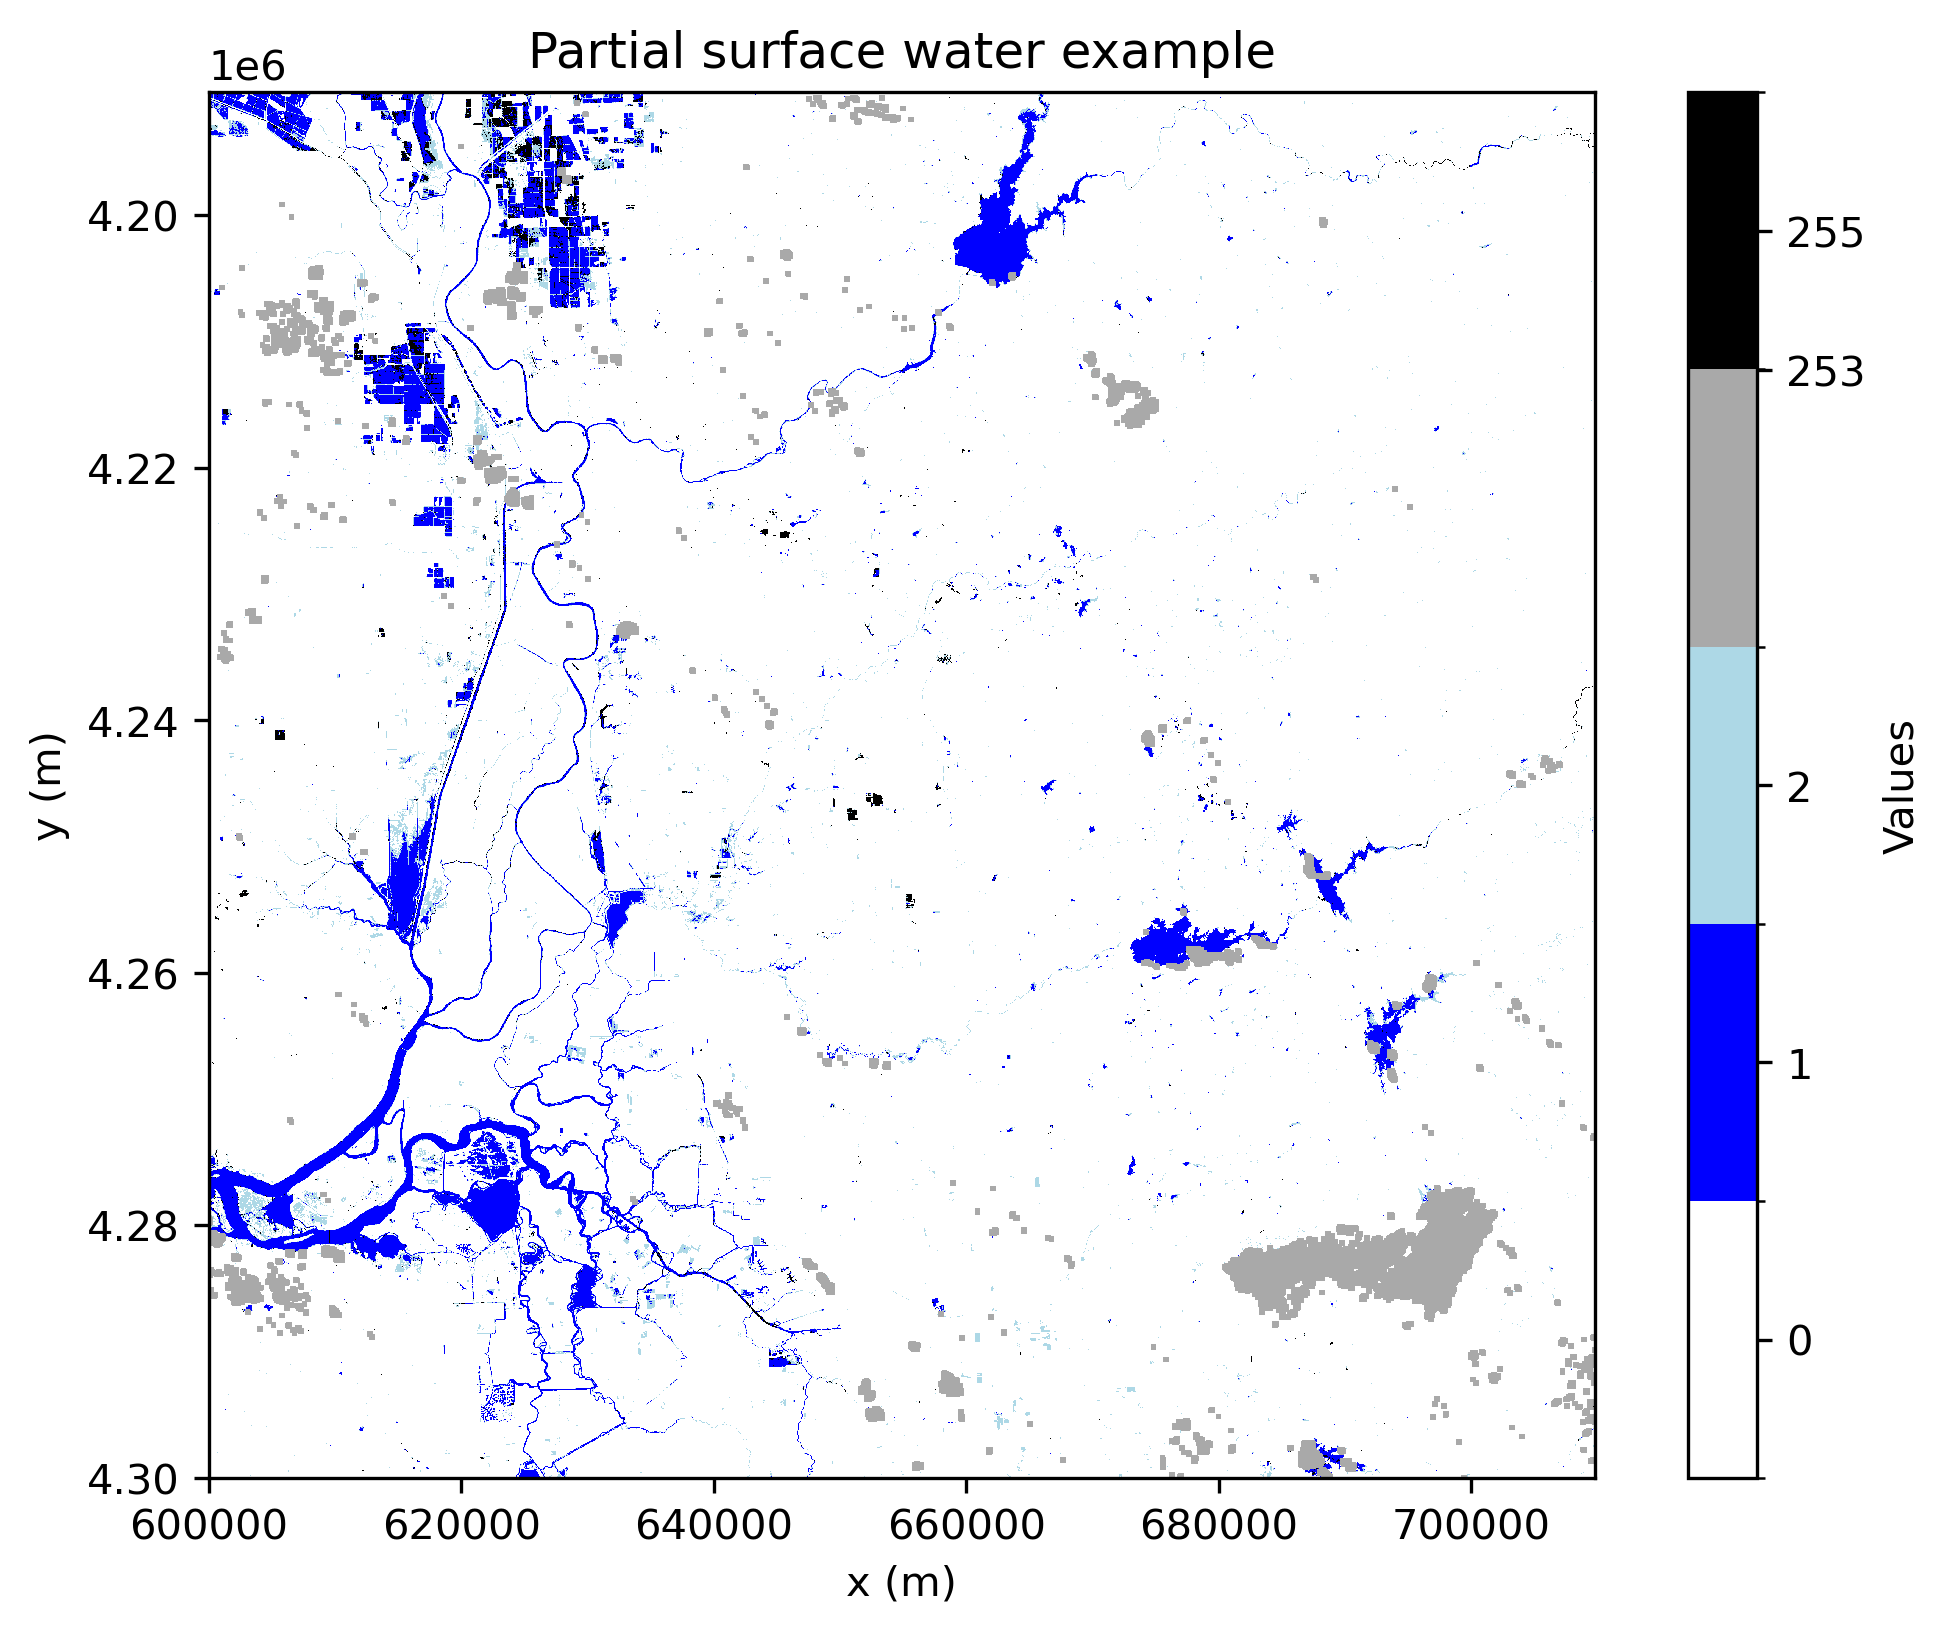

In [6]:
### DSWx HLS data classes ###
# 0: not water
# 1: open water
# 2: partial surface water
# 252: snow/ice
# 253: cloud/cloud shadow
# 254: ocean masked
# 255: no data

### DSWx S1 data classes ###
# 0: not water
# 1: open water
# 3: inundated vegetation
# 250: HAND mask
# 251: layover/shadow mask
# 255: no data

# Set HLS classes >199 (except cloud) to 255
whole_data_HLS_WTR[(whole_data_HLS_WTR > 199) & (whole_data_HLS_WTR != 253)] = 255  # (temporarily) regard data larger than 199 (except cloud) as no data

# Visualize a single layer (example: index 23)
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(whole_data_HLS_WTR[:,:,23], cmap=HLS_compare_cmap, norm=HLS_compare_norm,
           interpolation='none', extent=[x[0], x[-1], y[0], y[-1]])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Partial surface water example')
plt.colorbar(ticks=[0,1,2,253,255], label='Values')


In [8]:
def generate_water_occurrence_map(data):
    """
    Generate a water occurrence map for the 3D array excluding nonvalid (255) data.

    Parameters:
        data (numpy.ndarray): A 3D numpy array (time, height, width).

    Returns:
        numpy.ndarray: A 2D probability map.
    """
    # Mask to exclude cloud(253) and nonvalid(255) pixels
    valid_mask = (data != 253) & (data != 255)

    # Count the occurrences of 1s and valid (non-255) observations for each pixel
    count_ones = np.sum((data == 1) & valid_mask, axis=-1)
    count_valid = np.sum(valid_mask, axis=-1)

    # Calculate probability, avoiding division by zero
    water_occurrence_map = np.divide(
        count_ones, count_valid, where=(count_valid > 0), out=np.full(count_ones.shape, np.nan, dtype=float)
    )

    # Pixels with 0 < probability < 1 to be used for features
    mask_features = (water_occurrence_map > 0) & (water_occurrence_map < 1)

    return water_occurrence_map, mask_features

# Simplify S1 data classes
whole_data_S1_WTR[whole_data_S1_WTR == 3] = 0  # (temporarily) regard inundated vegetation as not water
whole_data_S1_WTR[whole_data_S1_WTR > 199] = 255  # (temporarily) regard data larger than 200 as no data

# generate S1 water occurrence map
water_occurrence_map_S1_WTR, mask_features_S1 = generate_water_occurrence_map(whole_data_S1_WTR)
# generate HLS water occurrence map
water_occurrence_map_HLS_WTR, mask_features_HLS = generate_water_occurrence_map(whole_data_HLS_WTR)


In [9]:
def simplify_HLS(data_HLS, water_occurrence_map_S1_WTR):
    """
    Apply simplification rules to HLS classification labels.
    """
    if data_HLS.ndim == 3:
        data_HLS[(data_HLS == 2) & (water_occurrence_map_S1_WTR[:,:,np.newaxis] == 1)] = 1 # (temporarily) regard partial surface water as open water if open water in S1 data
    else:
        data_HLS[(data_HLS == 2) & (water_occurrence_map_S1_WTR == 1)] = 1  # (temporarily) regard partial surface water as open water if open water in S1 data

    data_HLS[data_HLS == 2] = 0  # (temporarily) regard partial surface water as not water
    data_HLS[(data_HLS > 199) & (data_HLS != 253)] = 255  # (temporarily) regard data larger than 199 as no data

    return data_HLS

# Simplify HLS data classes
whole_data_HLS_WTR = simplify_HLS(whole_data_HLS_WTR, water_occurrence_map_S1_WTR)


In [10]:
# Utility functions for tile-based processing and feature filling
def add_cloud_to_test_data(test_data, fp, test_add_cloud):
    """
    Add cloud mask to test data if specified.
    """
    if test_add_cloud:
        original_test_data = np.copy(test_data)
        original_cloud = test_data == 253
        test_cloud = np.load(fp + "test_cloud_mask.npy")
        test_data[test_cloud] = 253
        return test_data, original_cloud
    else:
        return test_data, None

def divide_2d(array, num_div):
    """
    Divide a 2D array into tiles.
    """
    array_reshaped = array.reshape(
        num_div, int(array.shape[0]/num_div), num_div, int(array.shape[1]/num_div)
        )
    return [array_reshaped[i,:,j,:] for i in range(num_div) for j in range(num_div)]

def divide_into_tiles(array, num_div):
    """
    Divide a 2D or 3D array into tiles. (2D works same as divide_2d)
    """

    if array.ndim == 2:
        array_reshaped = array.reshape(
            num_div, int(array.shape[0]/num_div), num_div, int(array.shape[1]/num_div)
            )
        return [array_reshaped[i,:,j,:] for i in range(num_div) for j in range(num_div)]

    else:

        array_reshaped = array.reshape(
        num_div, int(array.shape[0]/num_div), num_div, int(array.shape[1]/num_div), int(array.shape[2])
    )
    return [array_reshaped[i,:,j,:,:] for i in range(num_div) for j in range(num_div)]

def get_p_xi(y, data_HLS_WTR, mask_valid_pixels, test_pixel_occurrence, idx):
    """
    Calculate conditional probability P(xi|Y).
    """
    idx_layer_y = np.atleast_1d(np.squeeze(np.argwhere(data_HLS_WTR[idx[0], idx[1], :] == y))) # idx of layers that gap pixel had value y (y=0 or y=1)
    count_Y = np.sum(mask_valid_pixels[:,idx_layer_y], axis = -1) # num of valid layers for each pixels excluding cloud and nonvalid
    count_xi = np.sum(test_pixel_occurrence[:,idx_layer_y], axis = -1) # count pixels that had same values as xi in those layers
    
    # P(xi|Y)
    p_xi = count_xi / count_Y
    p_xi[p_xi == 0] = 1 / data_HLS_WTR.shape[2] # Exception handling Eq. 8 in paper

    return p_xi

    def fill_cloud(data_HLS_WTR, mask_features_test, test_data,
                  fill_data, water_occurrence_map):
    """
    Process a single tile for gap-filling.
    """

    # only interested pixels in data_HLS_WTR are mask_test_features.
    features_data_HLS_WTR = data_HLS_WTR[mask_features_test, :]
    features_test_data = test_data[mask_features_test]

    test_pixel_occurrence = features_data_HLS_WTR == features_test_data[:, np.newaxis]
    mask_valid_pixels = (features_data_HLS_WTR == 0) | (features_data_HLS_WTR == 1)

    idx_fill_test = np.argwhere(fill_data == 253)
    final_data_temp = np.copy(fill_data)

    for idx in idx_fill_test:
        
        # exception case
        if np.isnan(water_occurrence_map[tuple(idx)]):
            final_data_temp[tuple(idx)] = 255
            continue

        # P(Y)
        p_y_1 = water_occurrence_map[tuple(idx)]
        p_y_0 = 1 - p_y_1

        # P(xi|y=0)
        p_xi_0 = get_p_xi(0, data_HLS_WTR, mask_valid_pixels, test_pixel_occurrence, idx)
        # P(xi|y=1)
        p_xi_1 = get_p_xi(1, data_HLS_WTR, mask_valid_pixels, test_pixel_occurrence, idx)

        y_0 = np.log(p_y_0) + np.sum(np.log(p_xi_0[(~np.isnan(p_xi_0)) & (~np.isnan(p_xi_1))]))
        y_1 = np.log(p_y_1) + np.sum(np.log(p_xi_1[(~np.isnan(p_xi_0)) & (~np.isnan(p_xi_1))]))

        final_data_temp[tuple(idx)] = 0 if y_0 > y_1 else 1

    return final_data_temp

IndentationError: expected an indented block after function definition on line 56 (736500600.py, line 58)

In [ ]:
#%% Load mask for Folsom Lake to filter analysis within this region
folsom_lake_mask = np.load("folsom_lake_mask.npy")

# Load preprocessed HLS tiles and their corresponding dates
loaded_data = np.load("HLS_tile2.npz", allow_pickle=True)
HLS_tile2 = loaded_data["HLS_tile2"]
HLS_dates = loaded_data["dates"]

def get_water_area(tile, mask):
    """
    Compute cloud rate over each time slice within a masked region.

    Parameters:
    -----------
    tile : np.ndarray
        3D array (rows x cols x time) of classified HLS/S1 data
    mask : np.ndarray
        2D binary mask (1 inside lake, 0 outside)

    Returns:
    --------
    cloud_rate : np.ndarray
        Array of cloud fraction for each time layer
    """
    #water_area = np.zeros(tile.shape[2])
    cloud_rate = np.zeros(tile.shape[2])
    #nodata_rate = np.zeros(tile.shape[2])
    for k in range(tile.shape[2]):    
        #water_area[k] = np.sum(tile[:,:,k]*folsom_lake_mask == 1)
        #cloud_rate[k] = np.sum(tile[:,:,k]*folsom_lake_mask == 253)
        #nodata_rate[k] = np.sum(tile[:,:,k]*folsom_lake_mask == 255)
        cloud_rate[k] = np.sum(tile[:,:,k]*folsom_lake_mask == 253)/np.sum(folsom_lake_mask)
   
    #water_area[water_area == 0] = np.nan
    #water_area[nodata_rate > 1e2] = np.nan

    #return water_area, cloud_rate, nodata_rate
    return cloud_rate

# Get cloud rates and filter out time steps with too much cloud
cloud_rate_HLS = get_water_area(HLS_tile2, folsom_lake_mask)
cloud85_mask = cloud_rate_HLS < 0.85
cloud85_idx = np.where(cloud85_mask)[0]

In [ ]:
#%% User-defined options for filtering and filling strategy
use_S1 = False              # Use S1 data instead of HLS for filling
prior_3months = True        # Use past 3 months as training window
previous_year = True        # Also include data from same season in previous year
discard_cloud85 = True      # Discard HLS tiles with >85% cloud coverage

# Apply configuration based on flags
if use_S1:  # fill cloud with S1 data
    dates_WTR = np.copy(dates_S1_WTR)
    whole_data_WTR = np.copy(whole_data_S1_WTR)
    water_occurrence_map_WTR = water_occurrence_map_S1_WTR
    mask_features = mask_features_S1
    filename_data = "_S1"
else:  # fill cloud with HLS data
    if discard_cloud85:
        dates_WTR = (np.array(dates_HLS_WTR)[cloud85_mask]).tolist()
        whole_data_WTR = np.take(whole_data_HLS_WTR, cloud85_idx, axis=-1)#whole_data_HLS_WTR[:,:,cloud85_mask]
        filename_cloud = "_cloud85"
    else:
        dates_WTR = np.copy(dates_HLS_WTR)
        whole_data_WTR = np.copy(whole_data_HLS_WTR)
        filename_cloud = ""
    water_occurrence_map_WTR = water_occurrence_map_HLS_WTR
    mask_features = mask_features_HLS
    filename_data = ""

filename_window = "_filled_3months_prior" if prior_3months else "_filled_3months_middle"
filename_previous = "_previousyear" if previous_year else ""

# Print file tag for logging
print(mgrs_tile + filename_window + filename_data + filename_cloud + filename_previous)


In [ ]:
#%% Function to process and fill a single file

def process_file(k):
    """
    Process a single HLS WTR file: select training set, run filling, return filled data.
    """
    global dates_HLS_WTR, dates_WTR, whole_data_WTR, water_occurrence_map_WTR, mask_features

    # Determine time window for training data
    if prior_3months:
        start_date = dates_HLS_WTR[k] - timedelta(days=90)  # 3 months time window
        end_date = dates_HLS_WTR[k]                         # date of the test data
    else:
        start_date = dates_HLS_WTR[k] - timedelta(days=45)  # 3 months time window
        end_date = dates_HLS_WTR[k] + timedelta(days=45)    # before and after the test data

    # Skip if out of bounds
    if start_date < dates_WTR[0] or end_date > dates_WTR[-1]:
        return None

    # get indices within the time window
    get_3months_idx = [i for i, date in enumerate(dates_WTR) if start_date <= date < end_date]
    # crop data
    data_WTR = whole_data_WTR[:,:,get_3months_idx]

    # Optionally add data from previous year
    if previous_year:
        start_date -= timedelta(days=365)
        end_date -= timedelta(days=365)
        if start_date < dates_WTR[0] or end_date > dates_WTR[-1]:  # if data doesn't exist
            return None
        # get indices within the time window
        get_3months_idx = [i for i, date in enumerate(dates_WTR) if start_date <= date < end_date]
        # crop data
        data_WTR = np.concatenate((data_WTR, whole_data_WTR[:,:,get_3months_idx]), axis=2)

    # Load test image
    test_data, x, y = gdal_load(files_HLS_WTR[k], 1)

    # Simplify & modify test data
    test_data = simplify_HLS(test_data, water_occurrence_map_S1_WTR)
    # Add cloud for test 
    test_data, original_cloud = add_cloud_to_test_data(test_data, fp, test_add_cloud)

    # Feature pixels (xi): clear(not cloud, not nonvalid) pixels in test data to be filled
    mask_features_test = mask_features & (test_data != 253) & (test_data != 255) # clear pixel in test data & 0 < prop <1
    fill_data = np.copy(test_data)
    fill_data[(fill_data == 253) & (water_occurrence_map_WTR == 0)] = 0
    fill_data[(fill_data == 253) & (water_occurrence_map_WTR == 1)] = 1

    # Divide into 4x4 tiles to allow parallelization
    data_WTR_reshaped = data_WTR.reshape(4, data_WTR.shape[0]//4, 4, data_WTR.shape[1]//4, data_WTR.shape[2])
    data_WTR_tiles = [data_WTR_reshaped[i,:,j,:,:] for i in range(4) for j in range(4)]
    mask_features_test_tiles = divide_2d(mask_features_test, 4)
    test_data_tiles = divide_2d(test_data, 4)
    fill_data_tiles = divide_2d(fill_data, 4)
    water_occurrence_map_WTR_tiles = divide_2d(water_occurrence_map_WTR, 4)

    ##### Process tiles in parallel #####
    with ThreadPool(4) as pool:
        final_data_tiles = pool.starmap(fill_cloud, zip(data_WTR_tiles, mask_features_test_tiles, test_data_tiles, fill_data_tiles, water_occurrence_map_WTR_tiles))

    # Merge tiles into single image
    rows = [np.hstack(final_data_tiles[i:i+4]) for i in range(0, len(final_data_tiles), 4)]
    final_data = np.vstack(rows)

    # Optional logging
    if k % 20 == 0:
        print(f"Processing file {k}: {end_date}")

    return final_data, dates_HLS_WTR[k]


In [ ]:
# Run multiprocessing on all files

if __name__ == "__main__":
    num_workers = 8
    pool = mp.Pool(num_workers)

    # Parallel run for all HLS files
    results = pool.map(process_file, range(len(files_HLS_WTR)))

    pool.close()
    pool.join()

    # Filter out any skipped files (returns None)
    filled_HLS_WTR, dates_HLS_filled = zip(*[r for r in results if r is not None])

    # Stack final results into 3D array
    final_filled_HLS_WTR = np.stack(filled_HLS_WTR, axis = -1)


In [ ]:
#%% Save result to compressed .npz format
np.savez(
    mgrs_tile + filename_window + filename_data + filename_cloud + filename_previous + ".npz",
    final_filled_HLS_WTR = final_filled_HLS_WTR,
    dates = dates_HLS_filled
)